# Gibbs Ringing Artifact

In this example, we see the effect of Gibbs ringing artifact on the stress field. The original FFT methods used a **spectral** derivative ($D_k = i\xi_k$). This scheme has "global support," meaning the derivative at one point depends on *all* other points. At sharp material interfaces, this causes the **Gibbs phenomenon**, which appears as spurious oscillations ("ringing") in the stress/strain fields.

In this notebook, we solve the same problem using a local scheme

* `CentralDifference`: This scheme is mathematically equivalent to a **Linear Finite Element (LFE)** formulation on a regular grid. It is extremely effective at eliminating ringing artifacts and is highly recommended.
* `RotatedDifference`: This scheme (from Willot, 2015) is equivalent to a trilinear Finite Element formulation with **reduced integration** (like `HEX8R`). It is also very stable and robust.


In [1]:
import jax

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_platforms", "cpu")

import jax.numpy as jnp
import numpy as np

from jax import Array
import equinox as eqx

In [2]:
import matplotlib.pyplot as plt
from skimage.morphology import footprint_rectangle as rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable

from xpektra import (
    SpectralSpace,
    TensorOperator,
    make_field,
)
from xpektra.projection_operator import GalerkinProjection
from xpektra.solvers.nonlinear import (  # noqa: E402
    conjugate_gradient_while,
    newton_krylov_solver,
)

In `xpektra`, we can import various schemes from the `scheme` module.



In [3]:
from xpektra.scheme import RotatedDifference, Fourier, CentralDifference

In [4]:
def param(X, soft, hard):
    return soft * jnp.ones_like(X) * (X) + hard * jnp.ones_like(X) * (1 - X)


def test_microstructure(N, scheme, length):
    H, L = (N, N)
    r = int(H / 2)

    structure = np.zeros((H, L))
    structure[:r, -r:] += rectangle((r, r))
    structure = np.flipud(structure)
    structure = np.fliplr(structure)

    ndim = len(structure.shape)
    N = structure.shape[0]

    tensor = TensorOperator(dim=ndim)
    space = SpectralSpace(size=N, dim=ndim, length=length)

    if scheme == "rotated":
        scheme = RotatedDifference(space=space)
    elif scheme == "fourier":
        scheme = Fourier(space=space)
    elif scheme == "central":
        scheme = CentralDifference(space=space)
    else:
        raise ValueError(f"Invalid scheme: {scheme}")

    # material parameters
    phase_contrast = 1000.0

    # lames constant
    lambda_modulus = {"soft": 1.0, "hard": phase_contrast}
    shear_modulus = {"soft": 1.0, "hard": phase_contrast}

    bulk_modulus = {}
    bulk_modulus["soft"] = lambda_modulus["soft"] + 2 * shear_modulus["soft"] / 3
    bulk_modulus["hard"] = lambda_modulus["hard"] + 2 * shear_modulus["hard"] / 3

    # material parameters
    μ0 = param(
        structure, soft=shear_modulus["soft"], hard=shear_modulus["hard"]
    )  # shear     modulus
    λ0 = param(
        structure, soft=lambda_modulus["soft"], hard=lambda_modulus["hard"]
    )  # shear     modulus

    dofs_shape = make_field(dim=ndim, N=N, rank=2).shape

    @eqx.filter_jit
    def strain_energy(eps_flat: Array) -> Array:
        eps = eps_flat.reshape(dofs_shape)
        eps_sym = 0.5 * (eps + tensor.trans(eps))
        energy = 0.5 * jnp.multiply(λ0, tensor.trace(eps_sym) ** 2) + jnp.multiply(
            μ0, tensor.trace(tensor.dot(eps_sym, eps_sym))
        )
        return energy.sum()

    compute_stress = jax.jacrev(strain_energy)

    Ghat = GalerkinProjection(scheme=scheme).compute_operator()

    class Residual(eqx.Module):
        """A callable module that computes the residual vector."""

        Ghat: Array
        space: SpectralSpace = eqx.field(static=True)
        tensor_op: TensorOperator = eqx.field(static=True)
        dofs_shape: tuple = eqx.field(static=True)

        # We can even pre-define the stress function if it's always the same
        # For this example, we'll keep your original `compute_stress` function
        # available in the global scope.

        @eqx.filter_jit
        def __call__(self, eps_flat: Array) -> Array:
            """
            This makes instances of this class behave like a function.
            It takes only the flattened vector of unknowns, as required by the solver.
            """
            eps_flat = eps_flat.reshape(-1)
            sigma = compute_stress(
                eps_flat
            )  # Assumes compute_stress is defined elsewhere
            residual_field = self.space.ifft(
                self.tensor_op.ddot(
                    self.Ghat, self.space.fft(sigma.reshape(self.dofs_shape))
                )
            )
            return jnp.real(residual_field).reshape(-1)

    class Jacobian(eqx.Module):
        """A callable module that represents the Jacobian operator (tangent)."""

        Ghat: Array
        space: SpectralSpace = eqx.field(static=True)
        tensor_op: TensorOperator = eqx.field(static=True)
        dofs_shape: tuple = eqx.field(static=True)

        @eqx.filter_jit
        def __call__(self, deps_flat: Array) -> Array:
            """
            The Jacobian is a linear operator, so its __call__ method
            represents the Jacobian-vector product.
            """

            deps_flat = deps_flat.reshape(-1)
            dsigma = compute_stress(deps_flat)
            jvp_field = self.space.ifft(
                self.tensor_op.ddot(
                    self.Ghat, self.space.fft(dsigma.reshape(self.dofs_shape))
                )
            )
            return jnp.real(jvp_field).reshape(-1)

    eps = make_field(dim=ndim, N=N, rank=2)
    residual_fn = Residual(
        Ghat=Ghat, space=space, tensor_op=tensor, dofs_shape=eps.shape
    )
    jacobian_fn = Jacobian(
        Ghat=Ghat, space=space, tensor_op=tensor, dofs_shape=eps.shape
    )

    deps = make_field(dim=ndim, N=N, rank=2)
    deps[:, :, 0, 1] = 5e-1
    deps[:, :, 1, 0] = 5e-1

    b = -residual_fn(deps)
    eps = eps + deps

    final_state = newton_krylov_solver(
        state=(deps, b, eps),
        gradient=residual_fn,
        jacobian=jacobian_fn,
        tol=1e-10,
        max_iter=20,
        krylov_solver=conjugate_gradient_while,
        krylov_tol=1e-8,
        krylov_max_iter=20,
    )
    eps = final_state[2]

    sig = compute_stress(eps.reshape(-1)).reshape(dofs_shape)

    return sig.at[:, :, 0, 1].get(), structure


CG error = 1809191201.65288829803467
CG error = 180711.28018050763058
CG error = 46714.20145050955034
CG error = 14617.25232152038734
CG error = 5832.60556147543502
CG error = 2443.83593643315271
CG error = 3104.19137280566883
CG error = 617.37049513329100
CG error = 948.36543897089598
CG error = 128.09898665086399
CG error = 218.65737857994182
CG error = 30.50016032587660
CG error = 53.28210205587326
CG error = 7.52766917158625
CG error = 13.31919602243492
CG error = 1.89453184436791
CG error = 3.37115744654369
CG error = 0.48037877209262
CG error = 0.80269075397288
CG error = 0.10234122536706
Didnot converge, Residual value : 0.4409232351000785
CG error = 1809191201.65286087989807
CG error = 30528.61295430577957
CG error = 410.36880416236380
CG error = 40.45545602250905
CG error = 2.23355354083230
CG error = 0.20688884613287
CG error = 0.00879075648632
CG error = 0.00149052978184
CG error = 0.00006216270524
CG error = 0.00001368845104
CG error = 0.00000153014519
CG error = 0.00000032

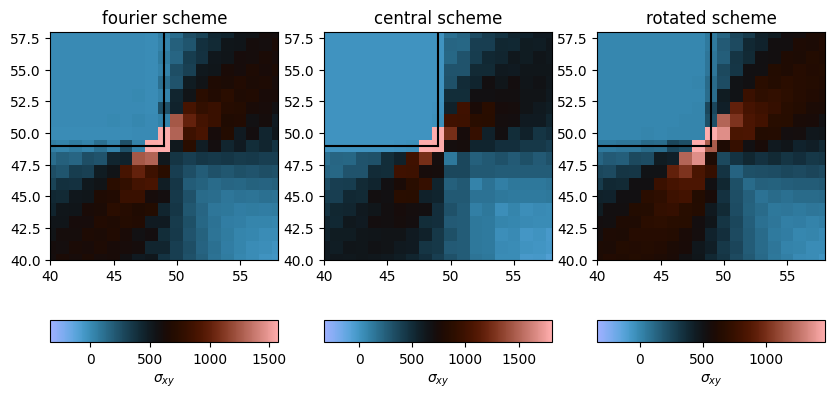

In [5]:
N = 99
length = 1


fig, axs = plt.subplots(1, 3, figsize=(10, 5))


for index, scheme in enumerate(["fourier", "central", "rotated"]):

    sig_xy, structure = test_microstructure(N=N, scheme=scheme, length=length)
    dx = length / N
    N_inset = int(0.1 / dx)


    cb = axs[index].imshow(sig_xy, origin="lower", cmap="berlin",)
    axs[index].set_title(f"{scheme} scheme")

    axs[index].set_xlim(int(N / 2) - N_inset, int(N / 2) + N_inset)
    axs[index].set_ylim(int(N / 2) - N_inset, int(N / 2) + N_inset)
    axs[index].plot(
        [int(N / 2) - N_inset, int(N / 2)], [int(N / 2), int(N / 2)], color="k", zorder=20
    )
    axs[index].plot(
        [int(N / 2), int(N / 2)],
        [int(N / 2), int(N / 2) + N_inset],
        color="k",
        zorder=20,
    )

    divider = make_axes_locatable(axs[index])
    cax = divider.append_axes("bottom", size="10%", pad=0.6)
    fig.colorbar(cb, cax=cax, label=r"$\sigma_{xy}$", orientation="horizontal", location="bottom")

plt.show()

